# Relax_Inc_Challenge


This is the solution to the Relax Challenge. The following is an adaptation of the prompt and task to complete.

The data has two tables:

A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years.
A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

At first, we may think of this as a predictive task. However, this really is a feature selection problem where we want to know which features have the most predictive power. To that end, we will use the Boruta algorithm which uses feature selection using Random Forests. Now let's start the analysis.

## Data Wrangling

In [20]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime 

In [2]:
#read in engagement csv
df_eng = pd.read_csv('takehome_user_engagement.csv')
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
#read in users csv
df_use = pd.read_csv('takehome_users.csv', encoding = 'ISO-8859-1')
df_use.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
df_eng.describe()

,user_id,visited
count,207917.000000,207917.0
mean,5913.314197,1.0
std,3394.941674,0.0
min,1.000000,1.0
25%,3087.000000,1.0
50%,5682.000000,1.0
75%,8944.000000,1.0
max,12000.000000,1.0


In [6]:
#convert time_stamp to datetime format
df_eng['time_stamp'] = pd.to_datetime(df_eng['time_stamp'])
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    df_eng['user_id'].nunique(), len(df_eng)))

There were 8823 users and 207917 total logins


In [8]:
#check how many users and how many logins
print('There were {} users and {} total logins'.format(
    df_eng['user_id'].nunique(), len(df_eng)
))

There were 8823 users and 207917 total logins


In [9]:
# function to get the rolling count of the count of user_ids with frequency of 7 days
def get_rolling_count(grp, freq):
    return grp.rolling(freq, on='time_stamp')['user_id'].count()

In [11]:
# implement the rolling function after grouping the engagement table by user_id
df_eng['visits_7_days'] = df_eng.groupby('user_id', as_index=False, group_keys=False).apply(get_rolling_count, '7D')
df_eng.head(10)

,time_stamp,user_id,visited,visits_7_days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0
5,2013-12-31 03:45:04,2,1,2.0
6,2014-01-08 03:45:04,2,1,1.0
7,2014-02-03 03:45:04,2,1,1.0
8,2014-02-08 03:45:04,2,1,2.0
9,2014-02-09 03:45:04,2,1,3.0


In [12]:
# make a list containing the user_ids that satisfy the criteria of 3 logins within a 7 day period.
df_eng_counts = []

for index, row in df_eng.iterrows():
    if row.visits_7_days >= 3.0:
        if row.user_id not in df_eng_counts:
            df_eng_counts.append(row.user_id)

In [13]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [14]:
# fill NaNs of the 2 values with missing data
df_use = df_use.fillna(0)

In [15]:
#recheck our dataset for null values
for col in df_use.columns:
    pct_missing = np.mean(df_use[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

object_id - 0.0%
creation_time - 0.0%
name - 0.0%
email - 0.0%
creation_source - 0.0%
last_session_creation_time - 0.0%
opted_in_to_mailing_list - 0.0%
enabled_for_marketing_drip - 0.0%
org_id - 0.0%
invited_by_user_id - 0.0%


In [16]:
df_use.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,1.014115e+09,0.249500,0.149333,141.884583,3188.691333
std,3464.24595,6.087938e+08,0.432742,0.356432,124.056723,3869.027693
min,1.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,0.000000e+00,0.000000,0.000000,29.000000,0.000000
50%,6000.50000,1.368880e+09,0.000000,0.000000,108.000000,875.000000
75%,9000.25000,1.393729e+09,0.000000,0.000000,238.250000,6317.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [18]:
#convert time_stamp to datetime format
df_use['creation_time'] = pd.to_datetime(df_use['creation_time'])

In [21]:
# unix timestamp to string
df_use['last_session_creation_time'] = df_use['last_session_creation_time'].map(lambda x: datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))

# string to datetime
df_use['last_session_creation_time'] = pd.to_datetime(df_use['last_session_creation_time'])

In [22]:
# Make another list that shows '1' for user_id present in engagement_counts list and '0' when not. This is the target variabled
# and is added to the users table as 'adopted_user'
adopted_user = []

for i in df_use.object_id:
    if i in df_eng_counts:
        adopted_user.append(1)
    else:
        adopted_user.append(0)
        
df_use['adopted_user'] = adopted_user

In [23]:
# 5 Organizations with most users
df_use['org_id'].value_counts().head()

0    319
1    233
2    201
3    168
4    159
Name: org_id, dtype: int64

In [24]:
# 10 Users with most invites
df_use['invited_by_user_id'].value_counts().head()

0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
Name: invited_by_user_id, dtype: int64

In [25]:
# remove those two features
df_use = df_use.drop(['org_id', 'invited_by_user_id'], axis=1)

In [34]:
#create when last log longin
last_log_day = df['last_session_creation_time'] - df['creation_time']

# This difference is appended to a list
days = []
for i in last_log_day:
    val = i.days
    if val < 0:
        days.append(0)
    else:
        days.append(val)

# the list is added to the users data table
df['last_log_day'] = days

In [124]:
df = pd.concat([df_use, df_eng], axis=1, join='inner')
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted_user,time_stamp,user_id,visited,visits_7_days
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 23:53:30,1,0,0,2014-04-22 03:53:30,1,1,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 23:45:04,0,0,1,2013-11-15 03:45:04,2,1,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 19:14:52,0,0,0,2013-11-29 03:45:04,2,1,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 04:09:28,0,0,0,2013-12-09 03:45:04,2,1,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 05:14:20,0,0,0,2013-12-25 03:45:04,2,1,1.0


In [125]:
df['adopted_user'] = df['adopted_user'].astype(int)
df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
adopted_user                           int32
time_stamp                    datetime64[ns]
user_id                                int64
visited                                int64
visits_7_days                        float64
dtype: object

In [64]:
#Now that we've cleaned up our dataset we can take another look at the dataset
def ames_eda(df): 
    eda_df = {}
    eda_df['null_sum'] = df.isnull().sum()
    eda_df['null_pct'] = df.isnull().mean()
    eda_df['dtypes'] = df.dtypes
    eda_df['count'] = df.count()
    eda_df['mean'] = df.mean()
    eda_df['median'] = df.median()
    eda_df['std'] = df.std()
    eda_df['min'] = df.min()
    eda_df['max'] = df.max()
    return pd.DataFrame(eda_df)

ames_eda(df)

,null_sum,null_pct,dtypes,count,mean,median,std,min,max
adopted_user,0,0.0,int32,12000,0.133500,0.0,0.340128,0,1
creation_source,0,0.0,object,12000,NaN,NaN,NaN,GUEST_INVITE,SIGNUP_GOOGLE_AUTH
creation_time,0,0.0,datetime64[ns],12000,NaN,NaN,NaN,2012-05-31 00:43:27,2014-05-30 23:59:19
email,0,0.0,object,12000,NaN,NaN,NaN,AaliyahArmstrong@yahoo.com,zzxqnoiy@vhugu.com
enabled_for_marketing_drip,0,0.0,int64,12000,0.149333,0.0,0.356432,0,1
last_session_creation_time,0,0.0,datetime64[ns],12000,NaN,NaN,NaN,1969-12-31 19:00:00,2014-06-06 10:58:50
name,0,0.0,object,12000,NaN,NaN,NaN,Aachen David,Østergaard Torben
object_id,0,0.0,int64,12000,6000.500000,6000.5,3464.245950,1,12000
opted_in_to_mailing_list,0,0.0,int64,12000,0.249500,0.0,0.432742,0,1
time_stamp,0,0.0,datetime64[ns],12000,NaN,NaN,NaN,2012-06-03 19:28:08,2014-06-04 23:56:26


In [65]:
print('Number of adopted_users: ' + str((df['adopted_user'] == 1).sum()))

Number of adopted_users: 1602


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

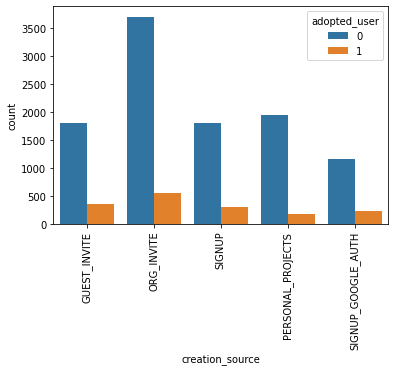

In [66]:
# Creation source and adopted user
sns.countplot(x='creation_source', data=df, hue='adopted_user')
plt.xticks(rotation=90)

In [67]:
#import sklearn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import  LabelEncoder

In [126]:
# encode the creation_source column
le = LabelEncoder()
df['creation_source_code'] = le.fit_transform(df.creation_source)

In [127]:
df.drop(['time_stamp','object_id', 'name', 'email', 'creation_source', 'creation_time', 'last_session_creation_time', 'user_id'], axis=1, inplace=True)

In [128]:
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']

In [129]:
# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

In [130]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (9600, 5)
Training Labels Shape: (9600,)
Testing Features Shape: (2400, 5)
Testing Labels Shape: (2400,)


In [131]:
features_to_encode = X_train.columns[X_train.dtypes==object].tolist()

In [132]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [133]:
seed = 50
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

In [134]:
X_train.dtypes

opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
visited                         int64
visits_7_days                 float64
creation_source_code            int32
dtype: object

In [135]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  [])],
                                   verbose=False)),
                ('randomforestclassifier',
                 RandomForestClas...ap=True, ccp_alpha=0.0,
                                        class_weight

In [136]:
y_pred = pipe.predict(X_test)

In [137]:
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 86.7 %


In [138]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

In [139]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.5951889385986595
Test ROC AUC  Score: 0.5922708834134616


In [140]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# standardize the features
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

std_X = StandardScaler().fit_transform(X)

In [141]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 23)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [142]:
y_pred = clf.predict(X_test)

confusion_matrix(y_test, y_pred)

array([[2089,    0],
       [ 311,    0]], dtype=int64)

In [143]:
rf_score = clf.score(X_test, y_test)
print('Model Accuracy: {}'.format(rf_score))

Model Accuracy: 0.8704166666666666


In [144]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

creation_source_code          0.444758
visits_7_days                 0.416931
opted_in_to_mailing_list      0.069158
enabled_for_marketing_drip    0.069153
visited                       0.000000
dtype: float64


Looking at our feature importance, we can see that our our creation_source_code value scored high, which was to be expected since this is how our users came into the software.  We can suggest to our client that they should look into encouraging their existing customers to keep logging in and using their software. We can also use this information to focus on the organizations who had the highest users as well as the lowest to suggest to our client how to better focus their resources towards these organizations. Focus more on the ones with the better user activity or focus on the lesser organizations to bring about better strategic plans to boost low user activity. We can see that certain marketing ideas didn't work as well.